## Imports

In [1]:
import pandas as pd
import numpy as np
import pyLDAvis.gensim
import matplotlib.pyplot as plt 
import time

import regex as re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec

/Users/jobethschroeter/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/jobethschroeter/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
/Users/jobethschroeter/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/nltk/lm/vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Counter, Iterable
/Users/jobethschroeter/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/scipy/sparse/sparsetoo

## Read in data
used ```word2vec_metadata.ipynb``` from Cynthia Chaing for text cleaning

In [2]:
articles = pd.read_csv('../data/merged_data.csv')
articles.isnull().sum()

paper_id            0
source              0
title               0
abstract         5021
publish_time        0
authors           432
journal          3441
url               119
discussion      21941
text_body           0
dtype: int64

In [3]:
# filled in missing abstract with text_body 
articles.loc[pd.isnull(articles['abstract']), 'abstract'] = articles['text_body']

In [4]:
articles.isnull().sum()

paper_id            0
source              0
title               0
abstract            0
publish_time        0
authors           432
journal          3441
url               119
discussion      21941
text_body           0
dtype: int64

## Tokenize text data

In [5]:
# Function that strips text of leading and trailing punctuation
import string

def strip_punc(list_of_words):
    return [word.strip(string.punctuation) for word in list_of_words]

In [95]:
# Remove stopwords and append other words that are not included in english stopwords

stop_words = stopwords.words('english')
stop_words.append('also')
stop_words.append('however')
stop_words.append('thus')

In [7]:
# Function that lowercases, tokenizes, and strips the text of any trailing punctuation

def clean_text(text):
    # Cast text as string (floats in body text)
    text = str(text)
    
    # Lowercase all words
    lower = text.lower()
    
    # Tokenizes by whitespace
    tokenizer = RegexpTokenizer('\s+', gaps=True)
    tokens = tokenizer.tokenize(lower)
    
    # Strip leading and trailing punctuation
    tokens_stripped = strip_punc(tokens)
    
    # Remove stop words
    stops = set(stop_words)
    tokens_stops = [tokens_stripped for tokens_stripped in tokens_stripped if tokens_stripped not in stops]
    
    # Return tokens stripped of trailing punctuation
    return tokens_stops

<>:11: DeprecationWarning: invalid escape sequence \s
<>:11: DeprecationWarning: invalid escape sequence \s
<>:11: DeprecationWarning: invalid escape sequence \s
<ipython-input-7-a57919df716b>:11: DeprecationWarning: invalid escape sequence \s
  tokenizer = RegexpTokenizer('\s+', gaps=True)


In [8]:
# Tokenize titles
articles['title'] = articles['title'].map(clean_text)

# Tokenize abstract
articles['abstract'] = articles['abstract'].map(clean_text)

# Tokenize body text
articles['text_body'] = articles['text_body'].map(clean_text)

## LDA

In [96]:
articles.dtypes

paper_id        object
source          object
title           object
abstract        object
publish_time    object
authors         object
journal         object
url             object
discussion      object
text_body       object
dtype: object

In [100]:
import multiprocessing
from time import time
import spacy
import logging

import gensim
from gensim import corpora
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

from sklearn.decomposition import LatentDirichletAllocation as LDA

# Utilized LDA and mallet code using:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#13viewthetopicsinldamodel

In [11]:
# Create Dictionary - using abstract 
id2word = corpora.Dictionary(articles['abstract'])

# Create Corpus
texts = articles['abstract']

# Term Doc Freq
corpus = [id2word.doc2bow(text) for text in texts]

# view
# each tuple is (token_id, token_count)
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 3), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 3), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 3), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 5), (54, 1), (55, 1), (56, 2), (57, 3), (58, 1), (59, 1), (60, 1), (61, 5), (62, 1), (63, 1), (64, 3), (65, 1), (66, 4), (67, 1), (68, 2), (69, 1), (70, 2), (71, 1), (72, 6), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1)]]


In [99]:
# human readable
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [13]:
# LDA model for 5 passes through abstract
# lda_model.save('lda_meta_5_abstract.model')
lda_model = gensim.models.ldamodel.LdaModel.load('lda_meta_5_abstract.model')

INFO - 12:29:04: loading LdaModel object from lda_meta_5_abstract.model
INFO - 12:29:04: loading expElogbeta from lda_meta_5_abstract.model.expElogbeta.npy with mmap=None
INFO - 12:29:04: setting ignored attribute dispatcher to None
INFO - 12:29:04: setting ignored attribute id2word to None
INFO - 12:29:04: setting ignored attribute state to None
INFO - 12:29:04: loaded lda_meta_5_abstract.model
INFO - 12:29:04: loading LdaState object from lda_meta_5_abstract.model.state
INFO - 12:29:04: loaded lda_meta_5_abstract.model.state


In [32]:
# USE SAVED MODEL:

# # build model
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
#                                            id2word=id2word,
#                                            num_topics=25,
#                                            update_every=1, 
#                                            chunksize=100,
#                                            passes=5,
#                                            alpha='auto', 
#                                            per_word_topics=True)

In [101]:
lda_model.print_topics(1)

INFO - 20:41:02: topic #9 (2.043): 0.038*"disease" + 0.021*"infectious" + 0.021*"may" + 0.021*"infection" + 0.017*"diseases" + 0.017*"vaccine" + 0.015*"infections" + 0.012*"new" + 0.011*"vaccines" + 0.011*"potential"


[(9,
  '0.038*"disease" + 0.021*"infectious" + 0.021*"may" + 0.021*"infection" + 0.017*"diseases" + 0.017*"vaccine" + 0.015*"infections" + 0.012*"new" + 0.011*"vaccines" + 0.011*"potential"')]

In [14]:
%%time
#print('Perplexity:', lda_model.log_perplexity(corpus))
# lower the beeter

coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=articles['abstract'], 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence:', coherence_lda)

INFO - 12:29:19: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 12:29:19: 1 batches submitted to accumulate stats from 64 documents (4602 virtual)
INFO - 12:29:19: 2 batches submitted to accumulate stats from 128 documents (6266 virtual)
INFO - 12:29:19: 3 batches submitted to accumulate stats from 192 documents (10009 virtual)
INFO - 12:29:20: 4 batches submitted to accumulate stats from 256 documents (16683 virtual)
INFO - 12:29:20: 5 batches submitted to accumulate stats from 320 documents (18562 virtual)
INFO - 12:29:20: 6 batches submitted to accumulate stats from 384 documents (21848 virtual)
INFO - 12:29:20: 7 batches submitted to accumulate stats from 448 documents (27386 virtual)
INFO - 12:29:20: 8 batches submitted to accumulate stats from 512 documents (28994 virtual)
INFO - 12:29:21: 9 batches submitted to accumulate stats from 576 documents (36174 virtual)
INFO - 12:29:21: 10 batches submitted to ac

INFO - 12:29:48: 87 batches submitted to accumulate stats from 5568 documents (612816 virtual)
INFO - 12:29:49: 88 batches submitted to accumulate stats from 5632 documents (615390 virtual)
INFO - 12:29:49: 89 batches submitted to accumulate stats from 5696 documents (617847 virtual)
INFO - 12:29:50: 90 batches submitted to accumulate stats from 5760 documents (622534 virtual)
INFO - 12:29:50: 91 batches submitted to accumulate stats from 5824 documents (625675 virtual)
INFO - 12:29:50: 92 batches submitted to accumulate stats from 5888 documents (629384 virtual)
INFO - 12:29:50: 93 batches submitted to accumulate stats from 5952 documents (633464 virtual)
INFO - 12:29:51: 94 batches submitted to accumulate stats from 6016 documents (636365 virtual)
INFO - 12:29:51: 95 batches submitted to accumulate stats from 6080 documents (638164 virtual)
INFO - 12:29:51: 96 batches submitted to accumulate stats from 6144 documents (650960 virtual)
INFO - 12:29:51: 97 batches submitted to accumulat

INFO - 12:30:15: 174 batches submitted to accumulate stats from 11136 documents (1647686 virtual)
INFO - 12:30:16: 175 batches submitted to accumulate stats from 11200 documents (1648365 virtual)
INFO - 12:30:16: 177 batches submitted to accumulate stats from 11328 documents (1648399 virtual)
INFO - 12:30:17: 178 batches submitted to accumulate stats from 11392 documents (1654572 virtual)
INFO - 12:30:17: 179 batches submitted to accumulate stats from 11456 documents (1658313 virtual)
INFO - 12:30:17: 180 batches submitted to accumulate stats from 11520 documents (1662040 virtual)
INFO - 12:30:18: 181 batches submitted to accumulate stats from 11584 documents (1670113 virtual)
INFO - 12:30:19: 182 batches submitted to accumulate stats from 11648 documents (1676972 virtual)
INFO - 12:30:20: 183 batches submitted to accumulate stats from 11712 documents (1688871 virtual)
INFO - 12:30:20: 184 batches submitted to accumulate stats from 11776 documents (1712919 virtual)
INFO - 12:30:22: 185

INFO - 12:31:35: 260 batches submitted to accumulate stats from 16640 documents (4208337 virtual)
INFO - 12:31:37: 261 batches submitted to accumulate stats from 16704 documents (4211150 virtual)
INFO - 12:31:38: 262 batches submitted to accumulate stats from 16768 documents (4223109 virtual)
INFO - 12:31:38: 263 batches submitted to accumulate stats from 16832 documents (4251622 virtual)
INFO - 12:31:38: 264 batches submitted to accumulate stats from 16896 documents (4278669 virtual)
INFO - 12:31:39: 265 batches submitted to accumulate stats from 16960 documents (4286618 virtual)
INFO - 12:31:43: 266 batches submitted to accumulate stats from 17024 documents (4387587 virtual)
INFO - 12:31:44: 267 batches submitted to accumulate stats from 17088 documents (4410589 virtual)
INFO - 12:31:45: 268 batches submitted to accumulate stats from 17152 documents (4432237 virtual)
INFO - 12:31:46: 269 batches submitted to accumulate stats from 17216 documents (4447745 virtual)
INFO - 12:31:47: 270

INFO - 12:38:37: 344 batches submitted to accumulate stats from 22016 documents (10867161 virtual)
INFO - 12:38:37: 345 batches submitted to accumulate stats from 22080 documents (10867666 virtual)
INFO - 12:38:40: 346 batches submitted to accumulate stats from 22144 documents (10869230 virtual)
INFO - 12:38:40: 347 batches submitted to accumulate stats from 22208 documents (10871231 virtual)
INFO - 12:38:42: 348 batches submitted to accumulate stats from 22272 documents (10873437 virtual)
INFO - 12:38:43: 349 batches submitted to accumulate stats from 22336 documents (10875904 virtual)
INFO - 12:38:44: 350 batches submitted to accumulate stats from 22400 documents (10878135 virtual)
INFO - 12:38:44: 351 batches submitted to accumulate stats from 22464 documents (10880548 virtual)
INFO - 12:38:45: 352 batches submitted to accumulate stats from 22528 documents (10882102 virtual)
INFO - 12:38:45: 353 batches submitted to accumulate stats from 22592 documents (10884466 virtual)
INFO - 12:

INFO - 12:40:47: 433 batches submitted to accumulate stats from 27712 documents (12888274 virtual)
INFO - 12:40:50: 434 batches submitted to accumulate stats from 27776 documents (12916987 virtual)
INFO - 12:40:52: 435 batches submitted to accumulate stats from 27840 documents (12934357 virtual)
INFO - 12:40:54: 436 batches submitted to accumulate stats from 27904 documents (12981826 virtual)
INFO - 12:40:57: 437 batches submitted to accumulate stats from 27968 documents (12989599 virtual)
INFO - 12:40:59: 438 batches submitted to accumulate stats from 28032 documents (13045978 virtual)
INFO - 12:41:00: 439 batches submitted to accumulate stats from 28096 documents (13110177 virtual)
INFO - 12:41:01: 440 batches submitted to accumulate stats from 28160 documents (13333416 virtual)
INFO - 12:41:02: 441 batches submitted to accumulate stats from 28224 documents (13362101 virtual)
INFO - 12:41:03: 442 batches submitted to accumulate stats from 28288 documents (13401191 virtual)
INFO - 12:

INFO - 12:43:26: 516 batches submitted to accumulate stats from 33024 documents (16445833 virtual)
INFO - 12:43:28: 517 batches submitted to accumulate stats from 33088 documents (16498599 virtual)
INFO - 12:43:31: 518 batches submitted to accumulate stats from 33152 documents (16520617 virtual)
INFO - 12:43:33: 519 batches submitted to accumulate stats from 33216 documents (16553954 virtual)
INFO - 12:43:36: 520 batches submitted to accumulate stats from 33280 documents (16579110 virtual)
INFO - 12:43:40: 521 batches submitted to accumulate stats from 33344 documents (16598053 virtual)
INFO - 12:43:43: 522 batches submitted to accumulate stats from 33408 documents (16620990 virtual)
INFO - 12:43:46: 523 batches submitted to accumulate stats from 33472 documents (16649996 virtual)
INFO - 12:43:48: 524 batches submitted to accumulate stats from 33536 documents (16689948 virtual)
INFO - 12:43:50: 525 batches submitted to accumulate stats from 33600 documents (16731649 virtual)
INFO - 12:

Coherence: 0.33398482784091743
CPU times: user 28.3 s, sys: 48.5 s, total: 1min 16s
Wall time: 20min 33s


In [27]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

INFO - 23:40:55: NumExpr defaulting to 4 threads.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.281380 -0.001304       1        1  14.441236
22     0.219656  0.022744       2        1  11.611935
6      0.247899 -0.120293       3        1  11.259387
11     0.225077  0.082451       4        1   9.703566
17     0.198645 -0.072414       5        1   9.185592
8      0.152302 -0.142362       6        1   5.904113
2      0.101581  0.046323       7        1   5.709924
20     0.076817  0.087284       8        1   5.132339
13     0.112147 -0.094915       9        1   3.972095
23     0.077040  0.313566      10        1   3.304034
1      0.047304 -0.165871      11        1   3.142285
19     0.023586 -0.112507      12        1   2.641660
21     0.024150  0.144423      13        1   2.262389
7     -0.020646  0.215620      14        1   2.152064
4     -0.112030  0.010755      15        1   1.465983
15    -0.098880 -0.063788      16        1   1.464385
5     -0.106055 -0.012087      17        1   1.426430
16    -0.129826 -0.067020      18        1   1.151499
12    -0.144355  0.001759      19        1   1.066937
0     -0.169181 -0.007951      20        1   0.690866
14    -0.198021 -0.038202      21        1   0.574246
10    -0.184900  0.001865      22        1   0.542357
24    -0.201336 -0.005682      23        1   0.504565
3     -0.197352 -0.012243      24        1   0.426669
18    -0.225003 -0.010153      25        1   0.263449, topic_info=              Term          Freq         Total Category  logprob  loglift
76           virus  45861.000000  45861.000000  Default  30.0000  30.0000
192          viral  28331.000000  28331.000000  Default  29.0000  29.0000
406    respiratory  25781.000000  25781.000000  Default  28.0000  28.0000
182        protein  19001.000000  19001.000000  Default  27.0000  27.0000
268        viruses  23061.000000  23061.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
9027            al      0.034674      1.456242  Topic25 -12.6535   2.2014
13359           cf      0.034674      1.456242  Topic25 -12.6535   2.2014
18231      chapter      0.034674      1.456243  Topic25 -12.6535   2.2014
4166         field      0.034674      1.456243  Topic25 -12.6535   2.2014
2039      abstract      0.034674      1.456260  Topic25 -12.6535   2.2014

[1157 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
598      19  0.999921        
1047     19  0.998912   0.001
600      19  0.986775    0.02
602      19  0.982765    0.04
792       4  0.980321       1
...     ...       ...     ...
3237     18  0.996741   yeast
3005     21  0.990830  yields
1130     10  0.999258   young
3844      4  0.999265       ±
1811     22  0.995484       ×

[1596 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 23, 7, 12, 18, 9, 3, 21, 14, 24, 2, 20, 22, 8, 5, 16, 6, 17, 13, 1, 15, 11, 25, 4, 19])

## Mallet Model

In [102]:
# pip install install-jdk
# # use Mallet-wrapper outside of Gensim
# # increases Coherence: better topic quality 

In [15]:
mallet_path = '../mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus,
                                             id2word=id2word,
                                             num_topics=25)
                                  

INFO - 12:50:32: serializing temporary corpus to /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/a08a10_corpus.txt
INFO - 12:51:41: converting temporary corpus to MALLET format with ../mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/a08a10_corpus.txt --output /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/a08a10_corpus.mallet
INFO - 12:52:16: training MALLET LDA with ../mallet-2.0.8/bin/mallet train-topics --input /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/a08a10_corpus.mallet --num-topics 25  --alpha 50 --optimize-interval 0 --num-threads 4 --output-state /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/a08a10_state.mallet.gz --output-doc-topics /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/a08a10_doctopics.txt --output-topic-keys /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/a08a10_topickeys.txt --num-iterations 1000 --inferencer-filename /var/folders/qw/

In [16]:
%%time
coherence_model_ldamallet = CoherenceModel(model=ldamallet,
                                          texts=articles['abstract'], 
                                          dictionary=id2word,
                                          coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score:', coherence_ldamallet)

INFO - 13:27:27: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 13:27:27: 1 batches submitted to accumulate stats from 64 documents (4476 virtual)
INFO - 13:27:27: 2 batches submitted to accumulate stats from 128 documents (6181 virtual)
INFO - 13:27:27: 3 batches submitted to accumulate stats from 192 documents (9895 virtual)
INFO - 13:27:27: 4 batches submitted to accumulate stats from 256 documents (15714 virtual)
INFO - 13:27:28: 5 batches submitted to accumulate stats from 320 documents (18456 virtual)
INFO - 13:27:28: 6 batches submitted to accumulate stats from 384 documents (21722 virtual)
INFO - 13:27:28: 7 batches submitted to accumulate stats from 448 documents (27150 virtual)
INFO - 13:27:28: 8 batches submitted to accumulate stats from 512 documents (28817 virtual)
INFO - 13:27:28: 9 batches submitted to accumulate stats from 576 documents (36112 virtual)
INFO - 13:27:29: 10 batches submitted to acc

INFO - 13:27:58: 87 batches submitted to accumulate stats from 5568 documents (610906 virtual)
INFO - 13:27:59: 88 batches submitted to accumulate stats from 5632 documents (613394 virtual)
INFO - 13:27:59: 89 batches submitted to accumulate stats from 5696 documents (615963 virtual)
INFO - 13:27:59: 90 batches submitted to accumulate stats from 5760 documents (620240 virtual)
INFO - 13:27:59: 91 batches submitted to accumulate stats from 5824 documents (623900 virtual)
INFO - 13:27:59: 92 batches submitted to accumulate stats from 5888 documents (627205 virtual)
INFO - 13:27:59: 93 batches submitted to accumulate stats from 5952 documents (630637 virtual)
INFO - 13:28:00: 94 batches submitted to accumulate stats from 6016 documents (632989 virtual)
INFO - 13:28:00: 95 batches submitted to accumulate stats from 6080 documents (636122 virtual)
INFO - 13:28:00: 96 batches submitted to accumulate stats from 6144 documents (647928 virtual)
INFO - 13:28:00: 97 batches submitted to accumulat

INFO - 13:28:27: 173 batches submitted to accumulate stats from 11072 documents (1595678 virtual)
INFO - 13:28:28: 174 batches submitted to accumulate stats from 11136 documents (1641886 virtual)
INFO - 13:28:28: 175 batches submitted to accumulate stats from 11200 documents (1646869 virtual)
INFO - 13:28:28: 178 batches submitted to accumulate stats from 11392 documents (1650184 virtual)
INFO - 13:28:29: 179 batches submitted to accumulate stats from 11456 documents (1653710 virtual)
INFO - 13:28:29: 180 batches submitted to accumulate stats from 11520 documents (1656526 virtual)
INFO - 13:28:29: 181 batches submitted to accumulate stats from 11584 documents (1662314 virtual)
INFO - 13:28:30: 182 batches submitted to accumulate stats from 11648 documents (1671305 virtual)
INFO - 13:28:31: 183 batches submitted to accumulate stats from 11712 documents (1678753 virtual)
INFO - 13:28:32: 184 batches submitted to accumulate stats from 11776 documents (1689388 virtual)
INFO - 13:28:32: 185

INFO - 13:29:33: 261 batches submitted to accumulate stats from 16704 documents (4200948 virtual)
INFO - 13:29:34: 262 batches submitted to accumulate stats from 16768 documents (4202869 virtual)
INFO - 13:29:35: 263 batches submitted to accumulate stats from 16832 documents (4218538 virtual)
INFO - 13:29:35: 264 batches submitted to accumulate stats from 16896 documents (4240138 virtual)
INFO - 13:29:38: 265 batches submitted to accumulate stats from 16960 documents (4250971 virtual)
INFO - 13:29:39: 266 batches submitted to accumulate stats from 17024 documents (4278211 virtual)
INFO - 13:29:42: 267 batches submitted to accumulate stats from 17088 documents (4288337 virtual)
INFO - 13:29:45: 268 batches submitted to accumulate stats from 17152 documents (4399833 virtual)
INFO - 13:29:47: 269 batches submitted to accumulate stats from 17216 documents (4417262 virtual)
INFO - 13:29:49: 270 batches submitted to accumulate stats from 17280 documents (4433383 virtual)
INFO - 13:29:50: 271

INFO - 13:32:40: 345 batches submitted to accumulate stats from 22080 documents (10852980 virtual)
INFO - 13:32:40: 346 batches submitted to accumulate stats from 22144 documents (10859409 virtual)
INFO - 13:32:41: 347 batches submitted to accumulate stats from 22208 documents (10860380 virtual)
INFO - 13:32:41: 348 batches submitted to accumulate stats from 22272 documents (10861590 virtual)
INFO - 13:32:43: 349 batches submitted to accumulate stats from 22336 documents (10863997 virtual)
INFO - 13:32:43: 350 batches submitted to accumulate stats from 22400 documents (10866183 virtual)
INFO - 13:32:43: 351 batches submitted to accumulate stats from 22464 documents (10868550 virtual)
INFO - 13:32:44: 352 batches submitted to accumulate stats from 22528 documents (10870641 virtual)
INFO - 13:32:44: 353 batches submitted to accumulate stats from 22592 documents (10872760 virtual)
INFO - 13:32:44: 354 batches submitted to accumulate stats from 22656 documents (10874665 virtual)
INFO - 13:

INFO - 13:33:44: 436 batches submitted to accumulate stats from 27904 documents (12881474 virtual)
INFO - 13:33:46: 437 batches submitted to accumulate stats from 27968 documents (12913725 virtual)
INFO - 13:33:46: 438 batches submitted to accumulate stats from 28032 documents (12928011 virtual)
INFO - 13:33:47: 439 batches submitted to accumulate stats from 28096 documents (12978435 virtual)
INFO - 13:33:49: 440 batches submitted to accumulate stats from 28160 documents (13008581 virtual)
INFO - 13:33:51: 441 batches submitted to accumulate stats from 28224 documents (13086204 virtual)
INFO - 13:33:51: 442 batches submitted to accumulate stats from 28288 documents (13308980 virtual)
INFO - 13:33:52: 443 batches submitted to accumulate stats from 28352 documents (13351531 virtual)
INFO - 13:33:52: 444 batches submitted to accumulate stats from 28416 documents (13376739 virtual)
INFO - 13:33:54: 445 batches submitted to accumulate stats from 28480 documents (13434439 virtual)
INFO - 13:

INFO - 13:35:23: 519 batches submitted to accumulate stats from 33216 documents (16455762 virtual)
INFO - 13:35:23: 520 batches submitted to accumulate stats from 33280 documents (16491649 virtual)
INFO - 13:35:25: 521 batches submitted to accumulate stats from 33344 documents (16511192 virtual)
INFO - 13:35:27: 522 batches submitted to accumulate stats from 33408 documents (16552703 virtual)
INFO - 13:35:27: 523 batches submitted to accumulate stats from 33472 documents (16575469 virtual)
INFO - 13:35:27: 524 batches submitted to accumulate stats from 33536 documents (16592189 virtual)
INFO - 13:35:29: 525 batches submitted to accumulate stats from 33600 documents (16611552 virtual)
INFO - 13:35:31: 526 batches submitted to accumulate stats from 33664 documents (16641723 virtual)
INFO - 13:35:32: 527 batches submitted to accumulate stats from 33728 documents (16698883 virtual)
INFO - 13:35:32: 528 batches submitted to accumulate stats from 33792 documents (16722249 virtual)
INFO - 13:

Coherence Score: 0.6276226999188619
CPU times: user 18.7 s, sys: 6.15 s, total: 24.9 s
Wall time: 9min 33s


In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

In [18]:
%%time
# this take 4.5 hours to run : optimal_model[2] saved 
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=articles['abstract'], 
                                                        start=15, limit=35, step=5)

INFO - 13:37:22: serializing temporary corpus to /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/dda72a_corpus.txt
INFO - 13:37:38: converting temporary corpus to MALLET format with ../mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/dda72a_corpus.txt --output /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/dda72a_corpus.mallet
INFO - 13:37:57: training MALLET LDA with ../mallet-2.0.8/bin/mallet train-topics --input /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/dda72a_corpus.mallet --num-topics 15  --alpha 50 --optimize-interval 0 --num-threads 4 --output-state /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/dda72a_state.mallet.gz --output-doc-topics /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/dda72a_doctopics.txt --output-topic-keys /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/dda72a_topickeys.txt --num-iterations 1000 --inferencer-filename /var/folders/qw/

INFO - 14:04:06: 74 batches submitted to accumulate stats from 4736 documents (566405 virtual)
INFO - 14:04:06: 75 batches submitted to accumulate stats from 4800 documents (570330 virtual)
INFO - 14:04:07: 76 batches submitted to accumulate stats from 4864 documents (572605 virtual)
INFO - 14:04:07: 77 batches submitted to accumulate stats from 4928 documents (577111 virtual)
INFO - 14:04:08: 78 batches submitted to accumulate stats from 4992 documents (581382 virtual)
INFO - 14:04:08: 79 batches submitted to accumulate stats from 5056 documents (584176 virtual)
INFO - 14:04:09: 80 batches submitted to accumulate stats from 5120 documents (586746 virtual)
INFO - 14:04:09: 81 batches submitted to accumulate stats from 5184 documents (591531 virtual)
INFO - 14:04:10: 82 batches submitted to accumulate stats from 5248 documents (595889 virtual)
INFO - 14:04:10: 83 batches submitted to accumulate stats from 5312 documents (599792 virtual)
INFO - 14:04:11: 84 batches submitted to accumulat

INFO - 14:04:55: 161 batches submitted to accumulate stats from 10304 documents (1389968 virtual)
INFO - 14:04:56: 162 batches submitted to accumulate stats from 10368 documents (1397596 virtual)
INFO - 14:04:57: 163 batches submitted to accumulate stats from 10432 documents (1405116 virtual)
INFO - 14:04:59: 164 batches submitted to accumulate stats from 10496 documents (1407715 virtual)
INFO - 14:05:01: 165 batches submitted to accumulate stats from 10560 documents (1409933 virtual)
INFO - 14:05:02: 166 batches submitted to accumulate stats from 10624 documents (1414516 virtual)
INFO - 14:05:03: 167 batches submitted to accumulate stats from 10688 documents (1415982 virtual)
INFO - 14:05:04: 168 batches submitted to accumulate stats from 10752 documents (1416775 virtual)
INFO - 14:05:04: 169 batches submitted to accumulate stats from 10816 documents (1417604 virtual)
INFO - 14:05:04: 170 batches submitted to accumulate stats from 10880 documents (1422284 virtual)
INFO - 14:05:05: 171

INFO - 14:06:39: 249 batches submitted to accumulate stats from 15936 documents (4076574 virtual)
INFO - 14:06:39: 250 batches submitted to accumulate stats from 16000 documents (4081105 virtual)
INFO - 14:06:39: 251 batches submitted to accumulate stats from 16064 documents (4083354 virtual)
INFO - 14:06:41: 252 batches submitted to accumulate stats from 16128 documents (4085994 virtual)
INFO - 14:06:41: 253 batches submitted to accumulate stats from 16192 documents (4093490 virtual)
INFO - 14:06:42: 254 batches submitted to accumulate stats from 16256 documents (4098246 virtual)
INFO - 14:06:42: 255 batches submitted to accumulate stats from 16320 documents (4106760 virtual)
INFO - 14:06:43: 256 batches submitted to accumulate stats from 16384 documents (4141218 virtual)
INFO - 14:06:45: 257 batches submitted to accumulate stats from 16448 documents (4146170 virtual)
INFO - 14:06:46: 258 batches submitted to accumulate stats from 16512 documents (4162126 virtual)
INFO - 14:06:47: 259

INFO - 14:12:57: 335 batches submitted to accumulate stats from 21440 documents (10513127 virtual)
INFO - 14:13:02: 336 batches submitted to accumulate stats from 21504 documents (10536411 virtual)
INFO - 14:13:08: 337 batches submitted to accumulate stats from 21568 documents (10546966 virtual)
INFO - 14:13:15: 338 batches submitted to accumulate stats from 21632 documents (10567066 virtual)
INFO - 14:13:31: 339 batches submitted to accumulate stats from 21696 documents (10760460 virtual)
INFO - 14:13:34: 340 batches submitted to accumulate stats from 21760 documents (10786166 virtual)
INFO - 14:13:36: 341 batches submitted to accumulate stats from 21824 documents (10802115 virtual)
INFO - 14:13:36: 342 batches submitted to accumulate stats from 21888 documents (10813772 virtual)
INFO - 14:13:37: 343 batches submitted to accumulate stats from 21952 documents (10829685 virtual)
INFO - 14:13:42: 344 batches submitted to accumulate stats from 22016 documents (10844494 virtual)
INFO - 14:

INFO - 14:16:22: 426 batches submitted to accumulate stats from 27264 documents (12423387 virtual)
INFO - 14:16:29: 427 batches submitted to accumulate stats from 27328 documents (12480433 virtual)
INFO - 14:16:35: 428 batches submitted to accumulate stats from 27392 documents (12499815 virtual)
INFO - 14:16:36: 429 batches submitted to accumulate stats from 27456 documents (12509260 virtual)
INFO - 14:16:41: 430 batches submitted to accumulate stats from 27520 documents (12587765 virtual)
INFO - 14:16:44: 431 batches submitted to accumulate stats from 27584 documents (12633800 virtual)
INFO - 14:16:50: 432 batches submitted to accumulate stats from 27648 documents (12669647 virtual)
INFO - 14:16:54: 433 batches submitted to accumulate stats from 27712 documents (12748821 virtual)
INFO - 14:16:56: 434 batches submitted to accumulate stats from 27776 documents (12817356 virtual)
INFO - 14:16:58: 435 batches submitted to accumulate stats from 27840 documents (12829682 virtual)
INFO - 14:

INFO - 14:22:17: 509 batches submitted to accumulate stats from 32576 documents (16090021 virtual)
INFO - 14:22:20: 510 batches submitted to accumulate stats from 32640 documents (16105905 virtual)
INFO - 14:22:28: 511 batches submitted to accumulate stats from 32704 documents (16141801 virtual)
INFO - 14:22:30: 512 batches submitted to accumulate stats from 32768 documents (16151874 virtual)
INFO - 14:22:31: 513 batches submitted to accumulate stats from 32832 documents (16190928 virtual)
INFO - 14:22:34: 514 batches submitted to accumulate stats from 32896 documents (16229430 virtual)
INFO - 14:22:36: 515 batches submitted to accumulate stats from 32960 documents (16344984 virtual)
INFO - 14:22:38: 516 batches submitted to accumulate stats from 33024 documents (16352586 virtual)
INFO - 14:22:38: 517 batches submitted to accumulate stats from 33088 documents (16369394 virtual)
INFO - 14:22:41: 518 batches submitted to accumulate stats from 33152 documents (16392321 virtual)
INFO - 14:

INFO - 14:28:34: converting temporary corpus to MALLET format with ../mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/34086_corpus.txt --output /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/34086_corpus.mallet
INFO - 14:29:39: training MALLET LDA with ../mallet-2.0.8/bin/mallet train-topics --input /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/34086_corpus.mallet --num-topics 20  --alpha 50 --optimize-interval 0 --num-threads 4 --output-state /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/34086_state.mallet.gz --output-doc-topics /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/34086_doctopics.txt --output-topic-keys /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/34086_topickeys.txt --num-iterations 1000 --inferencer-filename /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/34086_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 0
INFO - 15:41:26: load

INFO - 15:44:01: 75 batches submitted to accumulate stats from 4800 documents (570330 virtual)
INFO - 15:44:02: 76 batches submitted to accumulate stats from 4864 documents (572605 virtual)
INFO - 15:44:02: 77 batches submitted to accumulate stats from 4928 documents (577111 virtual)
INFO - 15:44:03: 78 batches submitted to accumulate stats from 4992 documents (581382 virtual)
INFO - 15:44:03: 79 batches submitted to accumulate stats from 5056 documents (584176 virtual)
INFO - 15:44:04: 80 batches submitted to accumulate stats from 5120 documents (586746 virtual)
INFO - 15:44:04: 81 batches submitted to accumulate stats from 5184 documents (591531 virtual)
INFO - 15:44:05: 82 batches submitted to accumulate stats from 5248 documents (595889 virtual)
INFO - 15:44:05: 83 batches submitted to accumulate stats from 5312 documents (599792 virtual)
INFO - 15:44:06: 84 batches submitted to accumulate stats from 5376 documents (601657 virtual)
INFO - 15:44:06: 85 batches submitted to accumulat

INFO - 15:44:47: 162 batches submitted to accumulate stats from 10368 documents (1397520 virtual)
INFO - 15:44:48: 163 batches submitted to accumulate stats from 10432 documents (1404995 virtual)
INFO - 15:44:49: 164 batches submitted to accumulate stats from 10496 documents (1407639 virtual)
INFO - 15:44:50: 165 batches submitted to accumulate stats from 10560 documents (1409814 virtual)
INFO - 15:44:50: 166 batches submitted to accumulate stats from 10624 documents (1413847 virtual)
INFO - 15:44:51: 167 batches submitted to accumulate stats from 10688 documents (1415830 virtual)
INFO - 15:44:51: 168 batches submitted to accumulate stats from 10752 documents (1416666 virtual)
INFO - 15:44:52: 169 batches submitted to accumulate stats from 10816 documents (1417493 virtual)
INFO - 15:44:52: 170 batches submitted to accumulate stats from 10880 documents (1422184 virtual)
INFO - 15:44:53: 171 batches submitted to accumulate stats from 10944 documents (1425130 virtual)
INFO - 15:44:53: 172

INFO - 15:46:27: 250 batches submitted to accumulate stats from 16000 documents (4080883 virtual)
INFO - 15:46:27: 251 batches submitted to accumulate stats from 16064 documents (4081263 virtual)
INFO - 15:46:29: 252 batches submitted to accumulate stats from 16128 documents (4085688 virtual)
INFO - 15:46:30: 253 batches submitted to accumulate stats from 16192 documents (4092891 virtual)
INFO - 15:46:31: 254 batches submitted to accumulate stats from 16256 documents (4097992 virtual)
INFO - 15:46:31: 255 batches submitted to accumulate stats from 16320 documents (4105355 virtual)
INFO - 15:46:33: 256 batches submitted to accumulate stats from 16384 documents (4141144 virtual)
INFO - 15:46:35: 257 batches submitted to accumulate stats from 16448 documents (4146109 virtual)
INFO - 15:46:37: 258 batches submitted to accumulate stats from 16512 documents (4161825 virtual)
INFO - 15:46:38: 259 batches submitted to accumulate stats from 16576 documents (4170145 virtual)
INFO - 15:46:42: 260

INFO - 15:51:17: 335 batches submitted to accumulate stats from 21440 documents (10511809 virtual)
INFO - 15:51:19: 336 batches submitted to accumulate stats from 21504 documents (10531065 virtual)
INFO - 15:51:22: 337 batches submitted to accumulate stats from 21568 documents (10543791 virtual)
INFO - 15:51:25: 338 batches submitted to accumulate stats from 21632 documents (10563583 virtual)
INFO - 15:51:32: 339 batches submitted to accumulate stats from 21696 documents (10759882 virtual)
INFO - 15:51:33: 340 batches submitted to accumulate stats from 21760 documents (10785146 virtual)
INFO - 15:51:35: 341 batches submitted to accumulate stats from 21824 documents (10800830 virtual)
INFO - 15:51:36: 342 batches submitted to accumulate stats from 21888 documents (10811160 virtual)
INFO - 15:51:38: 343 batches submitted to accumulate stats from 21952 documents (10826646 virtual)
INFO - 15:51:38: 344 batches submitted to accumulate stats from 22016 documents (10841908 virtual)
INFO - 15:

INFO - 15:52:50: 426 batches submitted to accumulate stats from 27264 documents (12422120 virtual)
INFO - 15:52:53: 427 batches submitted to accumulate stats from 27328 documents (12473681 virtual)
INFO - 15:53:02: 428 batches submitted to accumulate stats from 27392 documents (12499183 virtual)
INFO - 15:53:02: 429 batches submitted to accumulate stats from 27456 documents (12508572 virtual)
INFO - 15:53:04: 430 batches submitted to accumulate stats from 27520 documents (12575233 virtual)
INFO - 15:53:08: 431 batches submitted to accumulate stats from 27584 documents (12631865 virtual)
INFO - 15:53:14: 432 batches submitted to accumulate stats from 27648 documents (12664410 virtual)
INFO - 15:53:14: 433 batches submitted to accumulate stats from 27712 documents (12696690 virtual)
INFO - 15:53:15: 434 batches submitted to accumulate stats from 27776 documents (12781937 virtual)
INFO - 15:53:18: 435 batches submitted to accumulate stats from 27840 documents (12823120 virtual)
INFO - 15:

INFO - 15:56:26: 509 batches submitted to accumulate stats from 32576 documents (16087711 virtual)
INFO - 15:56:26: 510 batches submitted to accumulate stats from 32640 documents (16105213 virtual)
INFO - 15:56:30: 511 batches submitted to accumulate stats from 32704 documents (16131535 virtual)
INFO - 15:56:31: 512 batches submitted to accumulate stats from 32768 documents (16150755 virtual)
INFO - 15:56:35: 513 batches submitted to accumulate stats from 32832 documents (16183856 virtual)
INFO - 15:56:36: 514 batches submitted to accumulate stats from 32896 documents (16217217 virtual)
INFO - 15:56:36: 515 batches submitted to accumulate stats from 32960 documents (16286638 virtual)
INFO - 15:56:38: 516 batches submitted to accumulate stats from 33024 documents (16345984 virtual)
INFO - 15:56:39: 517 batches submitted to accumulate stats from 33088 documents (16362622 virtual)
INFO - 15:56:40: 518 batches submitted to accumulate stats from 33152 documents (16391519 virtual)
INFO - 15:

INFO - 16:00:30: converting temporary corpus to MALLET format with ../mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/f5e49c_corpus.txt --output /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/f5e49c_corpus.mallet
INFO - 16:01:09: training MALLET LDA with ../mallet-2.0.8/bin/mallet train-topics --input /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/f5e49c_corpus.mallet --num-topics 25  --alpha 50 --optimize-interval 0 --num-threads 4 --output-state /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/f5e49c_state.mallet.gz --output-doc-topics /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/f5e49c_doctopics.txt --output-topic-keys /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/f5e49c_topickeys.txt --num-iterations 1000 --inferencer-filename /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/f5e49c_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 0
INFO - 16:49:2

INFO - 16:51:39: 75 batches submitted to accumulate stats from 4800 documents (570330 virtual)
INFO - 16:51:40: 76 batches submitted to accumulate stats from 4864 documents (572605 virtual)
INFO - 16:51:40: 77 batches submitted to accumulate stats from 4928 documents (577111 virtual)
INFO - 16:51:41: 78 batches submitted to accumulate stats from 4992 documents (581382 virtual)
INFO - 16:51:41: 79 batches submitted to accumulate stats from 5056 documents (584176 virtual)
INFO - 16:51:43: 80 batches submitted to accumulate stats from 5120 documents (586746 virtual)
INFO - 16:51:43: 81 batches submitted to accumulate stats from 5184 documents (591531 virtual)
INFO - 16:51:44: 82 batches submitted to accumulate stats from 5248 documents (595889 virtual)
INFO - 16:51:44: 83 batches submitted to accumulate stats from 5312 documents (599792 virtual)
INFO - 16:51:46: 84 batches submitted to accumulate stats from 5376 documents (601657 virtual)
INFO - 16:51:46: 85 batches submitted to accumulat

INFO - 16:52:34: 162 batches submitted to accumulate stats from 10368 documents (1397520 virtual)
INFO - 16:52:35: 163 batches submitted to accumulate stats from 10432 documents (1404995 virtual)
INFO - 16:52:38: 164 batches submitted to accumulate stats from 10496 documents (1407639 virtual)
INFO - 16:52:38: 165 batches submitted to accumulate stats from 10560 documents (1409814 virtual)
INFO - 16:52:40: 166 batches submitted to accumulate stats from 10624 documents (1413847 virtual)
INFO - 16:52:41: 167 batches submitted to accumulate stats from 10688 documents (1415830 virtual)
INFO - 16:52:42: 168 batches submitted to accumulate stats from 10752 documents (1416666 virtual)
INFO - 16:52:42: 169 batches submitted to accumulate stats from 10816 documents (1417493 virtual)
INFO - 16:52:43: 170 batches submitted to accumulate stats from 10880 documents (1422184 virtual)
INFO - 16:52:44: 171 batches submitted to accumulate stats from 10944 documents (1425130 virtual)
INFO - 16:52:45: 172

INFO - 16:54:12: 250 batches submitted to accumulate stats from 16000 documents (4080720 virtual)
INFO - 16:54:12: 251 batches submitted to accumulate stats from 16064 documents (4081109 virtual)
INFO - 16:54:15: 252 batches submitted to accumulate stats from 16128 documents (4085545 virtual)
INFO - 16:54:15: 253 batches submitted to accumulate stats from 16192 documents (4092810 virtual)
INFO - 16:54:16: 254 batches submitted to accumulate stats from 16256 documents (4097840 virtual)
INFO - 16:54:17: 255 batches submitted to accumulate stats from 16320 documents (4104862 virtual)
INFO - 16:54:18: 256 batches submitted to accumulate stats from 16384 documents (4141078 virtual)
INFO - 16:54:20: 257 batches submitted to accumulate stats from 16448 documents (4146004 virtual)
INFO - 16:54:21: 258 batches submitted to accumulate stats from 16512 documents (4161646 virtual)
INFO - 16:54:22: 259 batches submitted to accumulate stats from 16576 documents (4170018 virtual)
INFO - 16:54:26: 260

INFO - 16:59:01: 334 batches submitted to accumulate stats from 21376 documents (10443128 virtual)
INFO - 16:59:05: 335 batches submitted to accumulate stats from 21440 documents (10484930 virtual)
INFO - 16:59:08: 336 batches submitted to accumulate stats from 21504 documents (10529494 virtual)
INFO - 16:59:12: 337 batches submitted to accumulate stats from 21568 documents (10541299 virtual)
INFO - 16:59:16: 338 batches submitted to accumulate stats from 21632 documents (10562017 virtual)
INFO - 16:59:25: 339 batches submitted to accumulate stats from 21696 documents (10759465 virtual)
INFO - 16:59:28: 340 batches submitted to accumulate stats from 21760 documents (10783311 virtual)
INFO - 16:59:30: 341 batches submitted to accumulate stats from 21824 documents (10799656 virtual)
INFO - 16:59:30: 342 batches submitted to accumulate stats from 21888 documents (10808985 virtual)
INFO - 16:59:30: 343 batches submitted to accumulate stats from 21952 documents (10825752 virtual)
INFO - 16:

INFO - 17:00:47: 426 batches submitted to accumulate stats from 27264 documents (12421734 virtual)
INFO - 17:00:49: 427 batches submitted to accumulate stats from 27328 documents (12473239 virtual)
INFO - 17:00:54: 428 batches submitted to accumulate stats from 27392 documents (12498572 virtual)
INFO - 17:00:55: 429 batches submitted to accumulate stats from 27456 documents (12506762 virtual)
INFO - 17:00:58: 430 batches submitted to accumulate stats from 27520 documents (12574871 virtual)
INFO - 17:00:59: 431 batches submitted to accumulate stats from 27584 documents (12631515 virtual)
INFO - 17:01:03: 432 batches submitted to accumulate stats from 27648 documents (12649662 virtual)
INFO - 17:01:04: 433 batches submitted to accumulate stats from 27712 documents (12696295 virtual)
INFO - 17:01:05: 434 batches submitted to accumulate stats from 27776 documents (12779812 virtual)
INFO - 17:01:05: 435 batches submitted to accumulate stats from 27840 documents (12822367 virtual)
INFO - 17:

INFO - 17:03:35: 509 batches submitted to accumulate stats from 32576 documents (16086297 virtual)
INFO - 17:03:37: 510 batches submitted to accumulate stats from 32640 documents (16104726 virtual)
INFO - 17:03:39: 511 batches submitted to accumulate stats from 32704 documents (16126617 virtual)
INFO - 17:03:39: 512 batches submitted to accumulate stats from 32768 documents (16149066 virtual)
INFO - 17:03:41: 513 batches submitted to accumulate stats from 32832 documents (16183491 virtual)
INFO - 17:03:42: 514 batches submitted to accumulate stats from 32896 documents (16207605 virtual)
INFO - 17:03:44: 515 batches submitted to accumulate stats from 32960 documents (16286316 virtual)
INFO - 17:03:45: 516 batches submitted to accumulate stats from 33024 documents (16345731 virtual)
INFO - 17:03:46: 517 batches submitted to accumulate stats from 33088 documents (16359465 virtual)
INFO - 17:03:48: 518 batches submitted to accumulate stats from 33152 documents (16391377 virtual)
INFO - 17:

INFO - 17:07:02: converting temporary corpus to MALLET format with ../mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/c4453d_corpus.txt --output /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/c4453d_corpus.mallet
INFO - 17:07:31: training MALLET LDA with ../mallet-2.0.8/bin/mallet train-topics --input /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/c4453d_corpus.mallet --num-topics 30  --alpha 50 --optimize-interval 0 --num-threads 4 --output-state /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/c4453d_state.mallet.gz --output-doc-topics /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/c4453d_doctopics.txt --output-topic-keys /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/c4453d_topickeys.txt --num-iterations 1000 --inferencer-filename /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/c4453d_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 0
INFO - 17:53:2

INFO - 17:55:29: 75 batches submitted to accumulate stats from 4800 documents (570215 virtual)
INFO - 17:55:29: 76 batches submitted to accumulate stats from 4864 documents (572512 virtual)
INFO - 17:55:30: 77 batches submitted to accumulate stats from 4928 documents (577036 virtual)
INFO - 17:55:30: 78 batches submitted to accumulate stats from 4992 documents (581254 virtual)
INFO - 17:55:31: 79 batches submitted to accumulate stats from 5056 documents (584159 virtual)
INFO - 17:55:31: 80 batches submitted to accumulate stats from 5120 documents (586656 virtual)
INFO - 17:55:31: 81 batches submitted to accumulate stats from 5184 documents (591445 virtual)
INFO - 17:55:32: 82 batches submitted to accumulate stats from 5248 documents (595803 virtual)
INFO - 17:55:32: 83 batches submitted to accumulate stats from 5312 documents (599598 virtual)
INFO - 17:55:33: 84 batches submitted to accumulate stats from 5376 documents (601569 virtual)
INFO - 17:55:33: 85 batches submitted to accumulat

INFO - 17:56:10: 162 batches submitted to accumulate stats from 10368 documents (1397416 virtual)
INFO - 17:56:11: 163 batches submitted to accumulate stats from 10432 documents (1404878 virtual)
INFO - 17:56:13: 164 batches submitted to accumulate stats from 10496 documents (1407529 virtual)
INFO - 17:56:13: 165 batches submitted to accumulate stats from 10560 documents (1409683 virtual)
INFO - 17:56:14: 166 batches submitted to accumulate stats from 10624 documents (1413750 virtual)
INFO - 17:56:14: 167 batches submitted to accumulate stats from 10688 documents (1415718 virtual)
INFO - 17:56:14: 168 batches submitted to accumulate stats from 10752 documents (1416644 virtual)
INFO - 17:56:15: 169 batches submitted to accumulate stats from 10816 documents (1417393 virtual)
INFO - 17:56:15: 170 batches submitted to accumulate stats from 10880 documents (1422048 virtual)
INFO - 17:56:15: 171 batches submitted to accumulate stats from 10944 documents (1425060 virtual)
INFO - 17:56:15: 172

INFO - 17:57:29: 250 batches submitted to accumulate stats from 16000 documents (4080717 virtual)
INFO - 17:57:30: 251 batches submitted to accumulate stats from 16064 documents (4081106 virtual)
INFO - 17:57:32: 252 batches submitted to accumulate stats from 16128 documents (4085542 virtual)
INFO - 17:57:33: 253 batches submitted to accumulate stats from 16192 documents (4092807 virtual)
INFO - 17:57:34: 254 batches submitted to accumulate stats from 16256 documents (4097837 virtual)
INFO - 17:57:34: 255 batches submitted to accumulate stats from 16320 documents (4104859 virtual)
INFO - 17:57:35: 256 batches submitted to accumulate stats from 16384 documents (4141075 virtual)
INFO - 17:57:36: 257 batches submitted to accumulate stats from 16448 documents (4146001 virtual)
INFO - 17:57:38: 258 batches submitted to accumulate stats from 16512 documents (4161643 virtual)
INFO - 17:57:39: 259 batches submitted to accumulate stats from 16576 documents (4170015 virtual)
INFO - 17:57:43: 260

INFO - 18:01:01: 334 batches submitted to accumulate stats from 21376 documents (10443036 virtual)
INFO - 18:01:03: 335 batches submitted to accumulate stats from 21440 documents (10484821 virtual)
INFO - 18:01:05: 336 batches submitted to accumulate stats from 21504 documents (10529368 virtual)
INFO - 18:01:06: 337 batches submitted to accumulate stats from 21568 documents (10540718 virtual)
INFO - 18:01:08: 338 batches submitted to accumulate stats from 21632 documents (10561814 virtual)
INFO - 18:01:11: 339 batches submitted to accumulate stats from 21696 documents (10758796 virtual)
INFO - 18:01:12: 340 batches submitted to accumulate stats from 21760 documents (10782852 virtual)
INFO - 18:01:14: 341 batches submitted to accumulate stats from 21824 documents (10799407 virtual)
INFO - 18:01:15: 342 batches submitted to accumulate stats from 21888 documents (10808417 virtual)
INFO - 18:01:15: 343 batches submitted to accumulate stats from 21952 documents (10825358 virtual)
INFO - 18:

INFO - 18:01:59: 426 batches submitted to accumulate stats from 27264 documents (12379478 virtual)
INFO - 18:02:01: 427 batches submitted to accumulate stats from 27328 documents (12472921 virtual)
INFO - 18:02:04: 428 batches submitted to accumulate stats from 27392 documents (12498249 virtual)
INFO - 18:02:04: 429 batches submitted to accumulate stats from 27456 documents (12506408 virtual)
INFO - 18:02:06: 430 batches submitted to accumulate stats from 27520 documents (12574521 virtual)
INFO - 18:02:06: 431 batches submitted to accumulate stats from 27584 documents (12599681 virtual)
INFO - 18:02:07: 432 batches submitted to accumulate stats from 27648 documents (12649384 virtual)
INFO - 18:02:08: 433 batches submitted to accumulate stats from 27712 documents (12695235 virtual)
INFO - 18:02:08: 434 batches submitted to accumulate stats from 27776 documents (12779482 virtual)
INFO - 18:02:11: 435 batches submitted to accumulate stats from 27840 documents (12822103 virtual)
INFO - 18:

INFO - 18:03:35: 509 batches submitted to accumulate stats from 32576 documents (16085064 virtual)
INFO - 18:03:35: 510 batches submitted to accumulate stats from 32640 documents (16104360 virtual)
INFO - 18:03:36: 511 batches submitted to accumulate stats from 32704 documents (16124708 virtual)
INFO - 18:03:37: 512 batches submitted to accumulate stats from 32768 documents (16143222 virtual)
INFO - 18:03:38: 513 batches submitted to accumulate stats from 32832 documents (16182833 virtual)
INFO - 18:03:39: 514 batches submitted to accumulate stats from 32896 documents (16200847 virtual)
INFO - 18:03:39: 515 batches submitted to accumulate stats from 32960 documents (16271056 virtual)
INFO - 18:03:40: 516 batches submitted to accumulate stats from 33024 documents (16343750 virtual)
INFO - 18:03:40: 517 batches submitted to accumulate stats from 33088 documents (16359114 virtual)
INFO - 18:03:41: 518 batches submitted to accumulate stats from 33152 documents (16389006 virtual)
INFO - 18:

INFO - 18:05:25: accumulated word occurrence stats for 19779321 virtual documents


CPU times: user 8min 34s, sys: 1min 30s, total: 10min 4s
Wall time: 4h 29min 10s


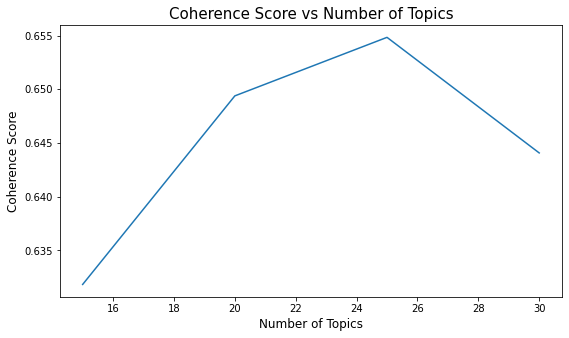

In [115]:
# graph
plt.figure(figsize=(9,5))

limit=35; start=15; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Number of Topics', fontsize=12)
plt.ylabel('Coherence Score', fontsize=12)
plt.title('Coherence Score vs Number of Topics', fontsize=15);

In [22]:
# print scores

for m, cv in zip(x, coherence_values):
    print('Number of Topics = ', m, ' has Coherence Value of', round(cv,2))

Number of Topics =  15  has Coherence Value of 0.63
Number of Topics =  20  has Coherence Value of 0.65
Number of Topics =  25  has Coherence Value of 0.65
Number of Topics =  30  has Coherence Value of 0.64


In [120]:
# select the model and print topics
# pick 25 topics 

optimal_model = model_list[2]
model_topics = optimal_model.show_topics()
optimal_model.print_topics(num_words=5)

INFO - 20:49:39: topic #20 (2.000): 0.035*"respiratory" + 0.028*"influenza" + 0.027*"virus" + 0.022*"viruses" + 0.021*"viral"
INFO - 20:49:39: topic #23 (2.000): 0.042*"virus" + 0.026*"viral" + 0.021*"viruses" + 0.018*"rna" + 0.012*"replication"
INFO - 20:49:39: topic #14 (2.000): 0.035*"covid-19" + 0.021*"cases" + 0.021*"sars" + 0.016*"coronavirus" + 0.015*"outbreak"
INFO - 20:49:39: topic #2 (2.000): 0.020*"protein" + 0.017*"proteins" + 0.008*"binding" + 0.008*"membrane" + 0.006*"structure"
INFO - 20:49:39: topic #8 (2.000): 0.082*"de" + 0.050*"la" + 0.037*"en" + 0.028*"el" + 0.023*"los"
INFO - 20:49:39: topic #12 (2.000): 0.009*"activity" + 0.007*"1" + 0.007*"2" + 0.006*"acid" + 0.005*"cell"
INFO - 20:49:39: topic #4 (2.000): 0.017*"children" + 0.012*"asthma" + 0.008*"infants" + 0.007*"patients" + 0.007*"symptoms"
INFO - 20:49:39: topic #3 (2.000): 0.007*"blood" + 0.005*"•" + 0.005*"fluid" + 0.004*"pressure" + 0.004*"signs"
INFO - 20:49:39: topic #0 (2.000): 0.026*"patients" + 0.015

[(20,
  '0.035*"respiratory" + 0.028*"influenza" + 0.027*"virus" + 0.022*"viruses" + 0.021*"viral"'),
 (23,
  '0.042*"virus" + 0.026*"viral" + 0.021*"viruses" + 0.018*"rna" + 0.012*"replication"'),
 (14,
  '0.035*"covid-19" + 0.021*"cases" + 0.021*"sars" + 0.016*"coronavirus" + 0.015*"outbreak"'),
 (2,
  '0.020*"protein" + 0.017*"proteins" + 0.008*"binding" + 0.008*"membrane" + 0.006*"structure"'),
 (8, '0.082*"de" + 0.050*"la" + 0.037*"en" + 0.028*"el" + 0.023*"los"'),
 (12,
  '0.009*"activity" + 0.007*"1" + 0.007*"2" + 0.006*"acid" + 0.005*"cell"'),
 (4,
  '0.017*"children" + 0.012*"asthma" + 0.008*"infants" + 0.007*"patients" + 0.007*"symptoms"'),
 (3,
  '0.007*"blood" + 0.005*"•" + 0.005*"fluid" + 0.004*"pressure" + 0.004*"signs"'),
 (0,
  '0.026*"patients" + 0.015*"pneumonia" + 0.014*"respiratory" + 0.013*"infection" + 0.012*"lung"'),
 (6, '0.057*"de" + 0.038*"la" + 0.025*"les" + 0.023*"des" + 0.021*"le"'),
 (11,
  '0.014*"cells" + 0.010*"lesions" + 0.006*"disease" + 0.005*"fig" +

### Optimal Model with 25 topics saved here:

In [25]:
# # optimal_model.save('optimal_model.model')
optimal_model = gensim.models.ldamodel.LdaModel.load('optimal_model.model')

INFO - 18:09:30: saving LdaMallet object under optimal_model.model, separately None
INFO - 18:09:30: storing np array 'word_topics' to optimal_model.model.word_topics.npy
INFO - 18:09:31: storing np array 'wordtopics' to optimal_model.model.wordtopics.npy
INFO - 18:09:39: saved optimal_model.model


### Assign each article to a topic
This function finds the dominant topic in each abstract and percent contribution to that topic<br>
Each document is assigned to a topic 

In [26]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=articles['abstract']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=articles['abstract'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

INFO - 18:15:04: serializing temporary corpus to /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/f5e49c_corpus.txt
INFO - 18:15:19: converting temporary corpus to MALLET format with ../mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/f5e49c_corpus.txt --output /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/f5e49c_corpus.mallet.infer --use-pipe-from /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/f5e49c_corpus.mallet
INFO - 18:15:45: inferring topics with MALLET LDA '../mallet-2.0.8/bin/mallet infer-topics --input /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/f5e49c_corpus.mallet.infer --inferencer /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/f5e49c_inferencer.mallet --output-doc-topics /var/folders/qw/2yp_lkcn7717q2_gzxswlf1h0000gn/T/f5e49c_doctopics.txt.infer --num-iterations 100 --doc-topics-threshold 0.0 --random-seed 0'


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,23.0,0.4516,"virus, viral, viruses, rna, replication, prote...","[nidovirus, subgenomic, mrnas, contain, leader..."
1,1,2.0,0.2833,"protein, proteins, binding, membrane, structur...","[ceacam1, member, carcinoembryonic, antigen, c..."
2,2,23.0,0.3064,"virus, viral, viruses, rna, replication, prote...","[hepatitis, c, virus, hcv, important, human, p..."
3,3,2.0,0.4939,"protein, proteins, binding, membrane, structur...","[key, enzyme, coronavirus, polyprotein, proces..."
4,4,23.0,0.5362,"virus, viral, viruses, rna, replication, prote...","[arteri, corona, toro, roniviruses, evolutiona..."


In [55]:
df_dominant_topic['Dominant_Topic'].value_counts().sort_index()

0.0     1283
1.0     1335
2.0     2893
3.0      199
4.0      507
5.0      432
6.0      247
7.0      263
8.0      341
9.0     2245
10.0     248
11.0     236
12.0    1658
13.0    2607
14.0    3728
15.0    4083
16.0     591
17.0      16
18.0      98
19.0    3556
20.0    3387
21.0    1706
22.0     846
23.0    4690
24.0     367
Name: Dominant_Topic, dtype: int64

### Compart to Original DataFrame

In [92]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,23.0,0.4516,"virus, viral, viruses, rna, replication, prote...","[nidovirus, subgenomic, mrnas, contain, leader..."
1,1,2.0,0.2833,"protein, proteins, binding, membrane, structur...","[ceacam1, member, carcinoembryonic, antigen, c..."
2,2,23.0,0.3064,"virus, viral, viruses, rna, replication, prote...","[hepatitis, c, virus, hcv, important, human, p..."
3,3,2.0,0.4939,"protein, proteins, binding, membrane, structur...","[key, enzyme, coronavirus, polyprotein, proces..."
4,4,23.0,0.5362,"virus, viral, viruses, rna, replication, prote...","[arteri, corona, toro, roniviruses, evolutiona..."


In [124]:
articles.head()

,paper_id,source,title,abstract,publish_time,authors,journal,url,discussion,text_body
0,b2897e1277f56641193a6db73825f707eed3e4c9,PMC,"[sequence, requirements, rna, strand, transfer...","[nidovirus, subgenomic, mrnas, contain, leader...",2001-12-17,"Pasternak, Alexander O.; van den Born, Erwin; ...",The EMBO Journal,http://europepmc.org/articles/pmc125340?pdf=re...,NaN,"[genetic, information, rna, viruses, organized..."
1,e3d0d482ebd9a8ba81c254cc433f314142e72174,PMC,"[crystal, structure, murine, sceacam1a[1,4, co...","[ceacam1, member, carcinoembryonic, antigen, c...",2002-05-01,"Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...",The EMBO Journal,http://europepmc.org/articles/pmc125375?pdf=re...,NaN,"[carcinoembryonic, antigen, cea, cd66e, initia..."
2,00b1d99e70f779eb4ede50059db469c65e8c1469,PMC,"[synthesis, novel, hepatitis, c, virus, protei...","[hepatitis, c, virus, hcv, important, human, p...",2001-07-16,"Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...",EMBO J,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,Previous studies have demonstrated that the lo...,"[hepatitis, c, virus, hcv, positive-stranded, ..."
3,cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0,PMC,"[structure, coronavirus, main, proteinase, rev...","[key, enzyme, coronavirus, polyprotein, proces...",2002-07-01,"Anand, Kanchan; Palm, Gottfried J.; Mesters, J...",The EMBO Journal,http://europepmc.org/articles/pmc126080?pdf=re...,NaN,"[transmissible, gastroenteritis, virus, tgev, ..."
4,dde02f11923815e6a16a31dd6298c46b109c5dfa,PMC,"[discontinuous, non-discontinuous, subgenomic,...","[arteri, corona, toro, roniviruses, evolutiona...",2002-12-01,"van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...",The EMBO Journal,http://europepmc.org/articles/pmc136939?pdf=re...,NaN,"[positive, strand, rna, viruses, developed, wi..."


In [32]:
# Most repersentative Doc for each of the 25 topics 

In [126]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8313,"patients, pneumonia, respiratory, infection, l...","[upper, respiratory, tract, symptoms, account,..."
1,1.0,0.6988,"patients, study, group, 2, 1, results, compare...","[introduction, aims, epidemiologic, data, demo..."
2,2.0,0.8409,"protein, proteins, binding, membrane, structur...","[guanine, nucleotide, exchange, factors, gefs,..."
3,3.0,0.8734,"blood, •, fluid, pressure, signs, heart, 2, no...","[event, suspect, peritonitis, negative, tap, a..."
4,4.0,0.8160,"children, asthma, infants, patients, symptoms,...","[james, w, mims, md, , maria, c, veling, md, b..."


In [125]:
# 25 topics
sent_topics_sorteddf_mallet.shape

(25, 4)

In [91]:
# pd.reset_option('max_colwidth')

In [90]:
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8313,"patients, pneumonia, respiratory, infection, lung, disease, treatment, pulmonary, therapy, clinical","[upper, respiratory, tract, symptoms, account, majority, primary, care, physician, office, visits, 48, symptoms, may, caused, common, colds, sinusitis, term, rhinosinusitis, developed, include, full, spectrum, common, cold, sinusitis, inflammation, infection, paranasal, sinuses, year, 20, million, cases, acute, sinusitis, 31, million, cases, chronic, sinusitis, united, sinusitis, categorized, acute, chronic, based, duration, symptoms, acute, sinusitis, symptoms, may, last, 4, weeks, chronic, sinusitis, symptoms, may, persist, 12, weeks, despite, optimal, medical, therapy, period, time, 4, 12, weeks, less, well, defined, authorities, classify, symptoms, period, subacute, sinusitis, colored, nasal, discharge, maxillary, toothache, poor, response, nasal, decongestants, abnormal, transillumination, best, predictors, sinusitis, physical, examination, usually, reveals, ...]"
1,1.0,0.6988,"patients, study, group, 2, 1, results, compared, age, data, significantly","[introduction, aims, epidemiologic, data, demonstrated, elevated, cancer, risk, hemodialysis, hd, patients, aim, present, study, evaluate, demographic, clinical, biochemical, determinants, cancer, development, hd, patients, methods, monitoring, dialysis, outcomes, mondo, consortium, consists, hd, databases, renal, research, institute, rri, clinics, us, fresenius, medical, care, fmc, clinics, europe, asia, pacific, ap, latin, america, la, kfh, clinics, germany, imperial, college, london, uk, hadassah, medical, center, jerusalem, israel, university, maastricht, netherlands, extracted, data, patients, survived, least, 12, months, start, hd, ninety-four, hd, patients, pre-existing, cancer, excluded, analysis, used, available, variables, construct, regression, models, predict, cancer, development, 2, year, follow-up, candidate, predictors, included, demographic, characteristics, age, sex, ...]"
2,2.0,0.8409,"protein, proteins, binding, membrane, structure, domain, cell, cells, activity, 1","[guanine, nucleotide, exchange, factors, gefs, , proteins, promote, release, gdp, guanin, e-nucleotide-binding, g, proteins, allows, gtp, bind, proteins, often, stabilize, nucleotide-free, form, released, upon, gtp, binding.gtpase-activating, proteins, gaps, , proteins, promote, gtp, hydrolysis, gtp-bound, guanine-nucleotide-binding, g, proteins, adp-ribosylation, factor, arf, proteins, gaps, critical, arfs, negligible, intrinsic, gtpase, activity, catalytic, regions, gaps, often, include, arg-finger, motif, inserts, gtp-binding, pocket, stimulate, hydrolysis, gtp.signalling, complex, gefs, gaps, initiate, physiological, responses, see, evidence, arf, proteins, acting, pairs, series, endoplasmic, reticulum, er)-golgi, system, plasma, membrane, review, emphasize, arf, proteins, function, network, arf, regulators, participate, regulators, integrate, arf, activities, g, protein, signalling, networks, well, initiating, distinct, ...]"
3,3.0,0.8734,"blood, •, fluid, pressure, signs, heart, 2, normal, include, patient","[event, suspect, peritonitis, negative, tap, abdominal, paracentesis, diagnostic, peritoneal, lavage, performed.to, perform, abdominal, paracentesis, follow, procedure, 1, place, patient, left, lateral, recumbency, clip, 4-to, 6-inch, square, umbilicus, center, 2, aseptically, scrub, clipped, area, antimicrobial, scrub, solution, 3, wearing, gloves, insert, 22-or, 20-gauge, needle, over-the-needle, catheter, four, quadrants, cranial, right, cranial, left, caudal, right, caudal, left, umbilicus, insert, needle, catheter, gently, twist, needle, push, abdominal, organs, away, tip, needle, local, anesthesia, typically, required, procedure, although, light, sedative, analgesic, may, necessary, severe, abdominal, pain, present, cases, fluid, flow, freely, one, needles, gently, aspirate, 3-to, 6-ml, syringe, aspirate, patient, stand

In [40]:
df_topic_sents_keywords.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,abstract
0,23.0,0.4516,"virus, viral, viruses, rna, replication, prote...","[nidovirus, subgenomic, mrnas, contain, leader..."
1,2.0,0.2833,"protein, proteins, binding, membrane, structur...","[ceacam1, member, carcinoembryonic, antigen, c..."
2,23.0,0.3064,"virus, viral, viruses, rna, replication, prote...","[hepatitis, c, virus, hcv, important, human, p..."
3,2.0,0.4939,"protein, proteins, binding, membrane, structur...","[key, enzyme, coronavirus, polyprotein, proces..."
4,23.0,0.5362,"virus, viral, viruses, rna, replication, prote...","[arteri, corona, toro, roniviruses, evolutiona..."


### Looking at specific values and topics

In [81]:
pd.set_option('display.max_colwidth', None)
#pd.reset_option('max_colwidth')

In [84]:
french = df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 6]

In [86]:
spanish = df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 8]

In [88]:
italian = df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 17]

In [89]:
german = df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 18]

### Convert Mallet Model to LDA 
Use pyLDAvis to show topics and salient terms

In [74]:
mallet_lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

INFO - 19:14:16: using serial LDA version on this node


In [75]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(mallet_lda_model, corpus, id2word)
vis

INFO - 19:22:41: NumExpr defaulting to 4 threads.
/Users/jobethschroeter/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/jobethschroeter/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/jobethschroeter/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11    -0.116196 -0.089082       1        1  6.686255
1     -0.036536  0.119051       2        1  6.290354
3     -0.108714  0.059639       3        1  5.650969
22    -0.126050  0.043236       4        1  5.527225
19    -0.063803 -0.232978       5        1  5.190558
7     -0.085955  0.015932       6        1  4.869671
21    -0.085806  0.023223       7        1  4.768088
13    -0.036345  0.117085       8        1  4.618961
0     -0.110196  0.137324       9        1  4.606830
9     -0.055883  0.168987      10        1  4.585946
16    -0.125836  0.044236      11        1  4.436007
4     -0.091036  0.117882      12        1  4.110661
10    -0.097020  0.053368      13        1  4.002497
2     -0.028672 -0.262138      14        1  3.851989
15    -0.031547 -0.016589      15        1  3.761112
5     -0.060691 -0.021530      16        1  3.476880
12    -0.040742 -0.127640      17        1  3.398995
24    -0.095005 -0.067286      18        1  3.387797
6      0.336529  0.029692      19        1  3.379907
23     0.034465 -0.302418      20        1  2.948258
14    -0.001931  0.156591      21        1  2.713749
20     0.027044 -0.042577      22        1  2.441898
8      0.385482  0.023967      23        1  2.302043
18     0.299160 -0.002594      24        1  1.730520
17     0.315283  0.054615      25        1  1.262829, topic_info=           Term           Freq          Total Category  logprob  loglift
4488         de   90470.000000   90470.000000  Default  30.0000  30.0000
5593         la   63029.000000   63029.000000  Default  29.0000  29.0000
75        virus   81460.000000   81460.000000  Default  28.0000  28.0000
175    patients  125383.000000  125383.000000  Default  27.0000  27.0000
7141         al   51697.000000   51697.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
8165         ad    1038.623031    2571.080997  Topic25  -5.6518   3.4654
8984         ha    1271.032989    4603.294201  Topic25  -5.4498   3.0849
14071        ai     881.056958    1625.334773  Topic25  -5.8163   3.7595
7141         al    1615.052249   51697.888345  Topic25  -5.2103   0.9058
5429         ed    1021.553374    4946.407484  Topic25  -5.6684   2.7945

[2798 rows x 6 columns], token_table=        Topic      Freq          Term
term                                 
512913      6  0.886704         0,049
512914      6  0.886704  0,049ifu/100
512919      6  0.886704          0,69
512921      6  0.886704         0,957
512924      6  0.886704         0-156
...       ...       ...           ...
512911      6  0.886704         −20ºc
512912      6  0.886704         −80ºc
313335     21  0.982794          ≥20x
231646      9  0.997221             
769486     19  0.878782         pour

[9138 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 2, 4, 23, 20, 8, 22, 14, 1, 10, 17, 5, 11, 3, 16, 6, 13, 25, 7, 24, 15, 21, 9, 19, 18])

In [94]:
pyLDAvis.save_html(vis, 'lda.html')